## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [2]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

img_list = []
img_d_list = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    img_list.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img_d = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        img_d_list.append(img_d)

In [3]:
def calibrateImage(img, objpoints, imgpoints):
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst, mtx, dist

def plotImage(img, undist, text1="", text2=""):
    # 1x2 plots of color images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title(text1, fontsize=30)
    ax2.imshow(undist)
    ax2.set_title(text2, fontsize=30)

def plotImageBinary(img, undist, text1="", text2=""):
    # 1x2 plots of grayscale images
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title(text1, fontsize=30)
    ax2.imshow(undist, cmap='gray')
    ax2.set_title(text2, fontsize=30)

def plotHistogram(hist, title='', xlabel='', ylabel=''):
    # Histogram visualization
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(hist)
    

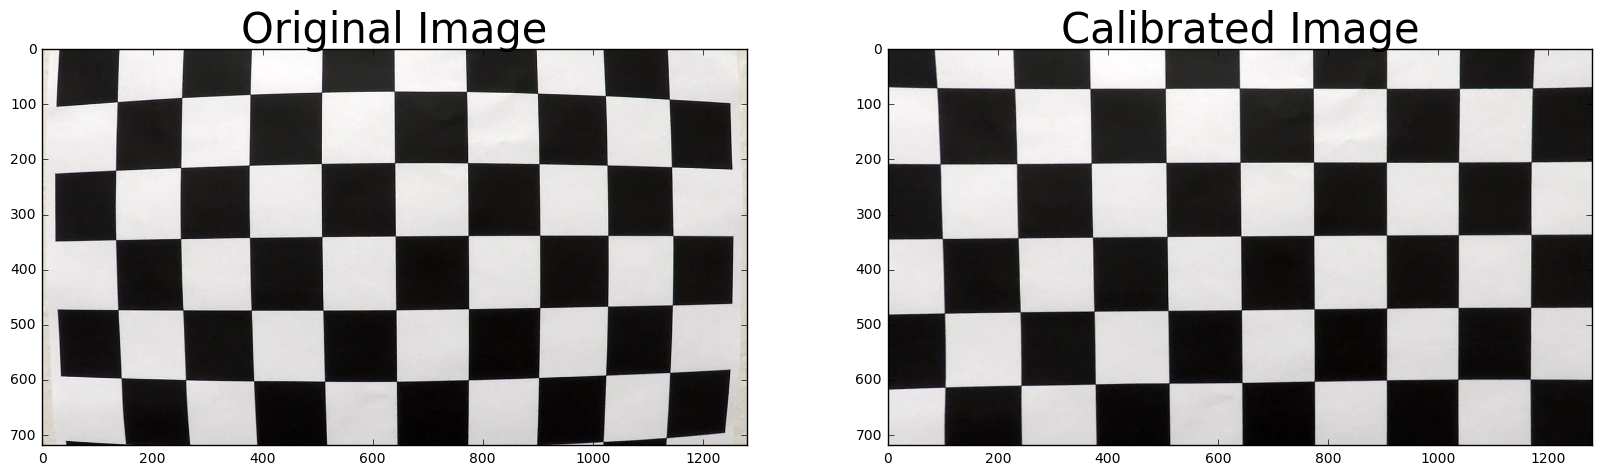

In [4]:
# Test undistortion on an image
img = cv2.imread('../test_images/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

undist, mtx, dist = calibrateImage(img, objpoints, imgpoints)

plotImage(img, undist, 'Original Image', 'Calibrated Image')

## Apply distortion correction to test images

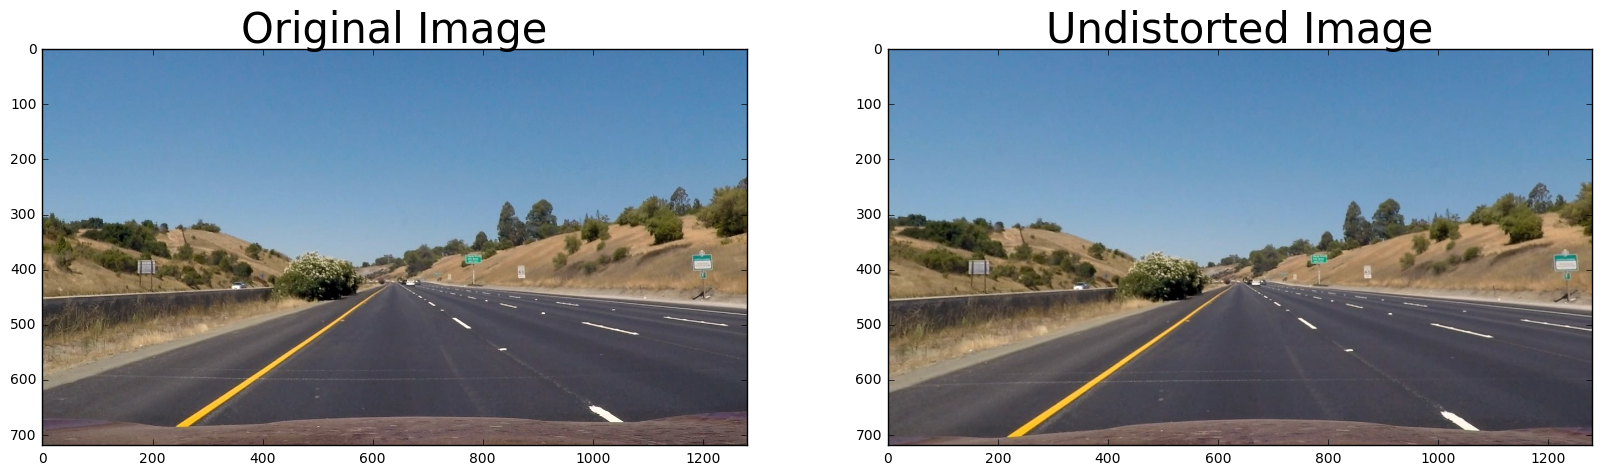

In [5]:
# Test undistortion on an image
img = cv2.imread('../test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

undist, mtx, dist = calibrateImage(img, objpoints, imgpoints)
#cv2.imwrite('../output_images/straight_lines1_undist.jpg',undist)

plotImage(img, undist, 'Original Image', 'Undistorted Image')

## Compute object and image points for bird's eye-view (perspective transform)

In [6]:
def warpImage(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, M_inv

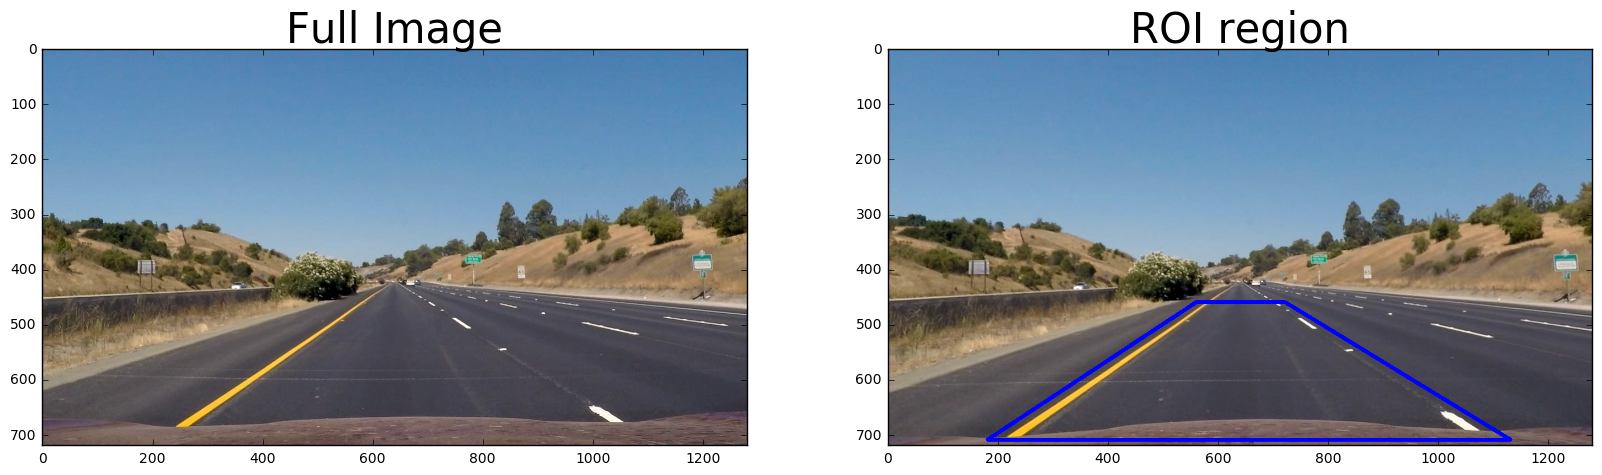

In [7]:
color = [255, 0, 0]
thickness = 5
ud_cp = np.copy(undist)

#Left Line
x1 = 560
y1 = 460
x2 = 180
y2 = 710
ud_cp = cv2.line(ud_cp, (x1, y1), (x2, y2), color, thickness)
src1 = np.float32([[x1, y1], [x2, y2]])

#Right Line
x1 = 720
y1 = 460
x2 = 1130
y2 = 710
ud_cp = cv2.line(ud_cp, (x1, y1), (x2, y2), color, thickness)
src2 = np.float32([[x2, y2], [x1, y1]])

#Top Line
x1 = 560
y1 = 460
x2 = 720
y2 = 460
ud_cp = cv2.line(ud_cp, (x1, y1), (x2, y2), color, thickness)

#Bot Line
x1 = 180
y1 = 710
x2 = 1130
y2 = 710
ud_cp = cv2.line(ud_cp, (x1, y1), (x2, y2), color, thickness)

plotImage(img, ud_cp, 'Full Image', 'ROI region')

In [8]:
offset = 100
dst = np.float32([[offset, offset], [offset, img_size[1]-offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [img_size[0]-offset, offset]])
src = np.vstack((src1, src2))

print('Source Points')
print(src)
print('Destination Points')
print(dst)

Source Points
[[  560.   460.]
 [  180.   710.]
 [ 1130.   710.]
 [  720.   460.]]
Destination Points
[[  100.   100.]
 [  100.   620.]
 [ 1180.   620.]
 [ 1180.   100.]]


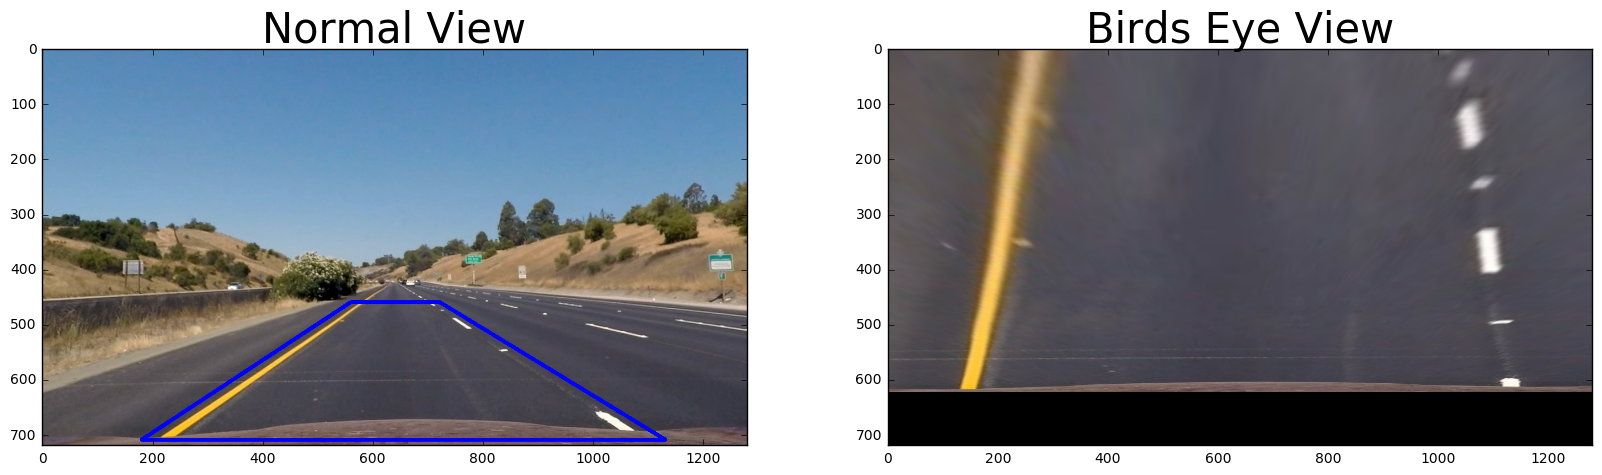

In [9]:
warped, M, M_inv = warpImage(undist, src, dst)
plotImage(ud_cp, warped, 'Normal View', 'Birds Eye View')

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel =3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print("Invalid orientation!")
    
    abs_sobelv = np.absolute(sobelv)
    scaled_sobel = np.uint8(255*abs_sobelv/np.max(abs_sobelv))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(grad_dir)
    sxbinary[(grad_dir >= thresh_min) & (grad_dir <= thresh_max)] = 1

    return sxbinary

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(hls, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary


In [11]:
# Choose a Sobel kernel size
def getBinaryImage(img):
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_binary = hls_select(hls, thresh=(150, 255))
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 150))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 150))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.3, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    
    return combined

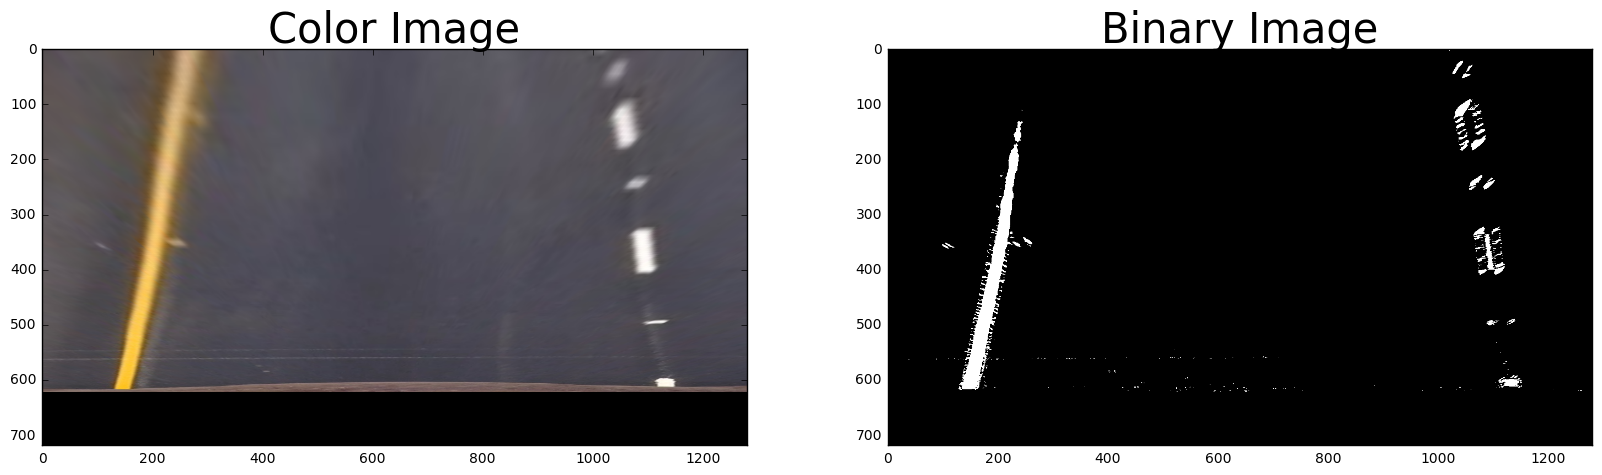

In [12]:
binary_warped = getBinaryImage(warped)
plotImageBinary(warped, binary_warped, 'Color Image', 'Binary Image')

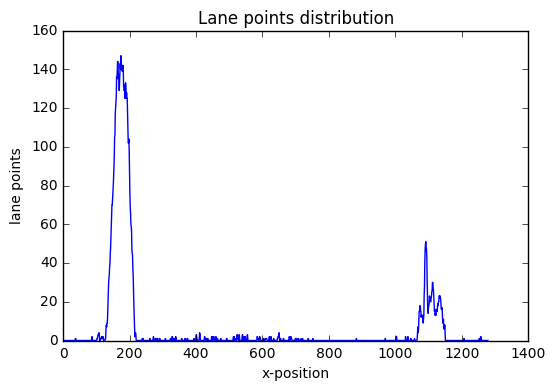

In [13]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plotHistogram(histogram, 'Lane points distribution', 'x-position', 'lane points')

## Fine left and right lanes and track them

In [14]:
def fitLine(binary_warped, left_fit, right_fit):    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx

In [15]:
def checkWithPrev(binary_warped, prev_fit, margin = 100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ref_line = prev_fit[0]*(nonzeroy**2) + prev_fit[1]*nonzeroy + prev_fit[2]
    #print('ref_line', ref_line)

    lane_inds = ((nonzerox > (ref_line - margin)) & (nonzerox < (ref_line + margin))) 

    # Again, extract left and right line pixel positions
    lane_x = nonzerox[lane_inds]
    lane_y = nonzeroy[lane_inds]
    
    # Fit a second order polynomial to each
    new_fit = np.polyfit(lane_y, lane_x, 2)
    
    return new_fit

In [16]:
def getNewBase(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    #out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base


In [17]:
def searchNew(binary_warped, x_base, margin=100):
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    x_current = x_base

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin

        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
        
        # Append these indices to the lists
        lane_inds.append(good_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)

    # Extract left and right line pixel positions
    lane_x = nonzerox[lane_inds]
    lane_y = nonzeroy[lane_inds] 

    # Fit a second order polynomial to each
    new_fit = np.polyfit(lane_y, lane_x, 2)
    
    return new_fit

In [18]:
leftx_base, rightx_base = getNewBase(binary_warped)

#Search left line
left_fit = searchNew(binary_warped, leftx_base)
#Search right line
right_fit = searchNew(binary_warped, rightx_base)

left_fitx, right_fitx = fitLine(binary_warped, left_fit, right_fit)
#plt.imshow(out_img)

In [19]:
def reprojectLane(binary_warped, undist, left_fitx, right_fitx, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    left_pt = pts_left[0,binary_warped.shape[0]-1]
    right_pt = pts_right[0,0]
    
    #print('left_pt', left_pt[0])
    #print('right_pt', right_pt[0])
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    return result, left_pt[0], right_pt[0]

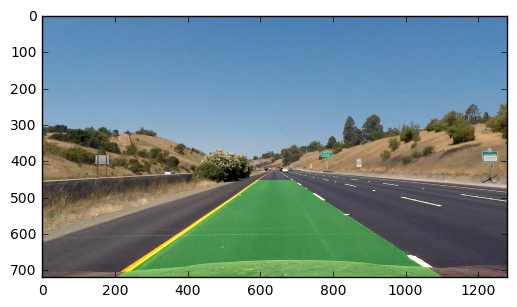

In [20]:
result , left_pt, right_pt = reprojectLane(binary_warped, undist, left_fitx, right_fitx, M_inv)
plt.imshow(result)

## Track detected and new lines, Radius of curvature and Drift from center

In [21]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = np.empty((0, 3), dtype='float')
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Average window size
        self.win_size = 0

In [22]:
def radiusOfCurvature(binary_warped, undist, leftx, rightx, left_pt, right_pt):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/binary_warped.shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/(right_pt - left_pt) # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    roc = np.mean(np.array([left_curverad, right_curverad]))
    cal_center = np.mean(np.array([left_pt, right_pt]))
    drift = ((binary_warped.shape[1] / 2) - cal_center) * xm_per_pix
    
    return roc, drift
    

In [23]:
def lane_detect(img, mtx, dist, src, dst, left_line, right_line):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped, M, M_inv = warpImage(undist, src, dst)
    binary_warped = getBinaryImage(warped)
    
    leftx_base, rightx_base = getNewBase(binary_warped)
    
    #Search left line    
    if(left_line.detected == False):
        left_fit = searchNew(binary_warped, leftx_base)
        left_line.detected = True
    else:
        left_fit = checkWithPrev(binary_warped, left_line.best_fit)

    #Search right line
    if(right_line.detected == False):    
        right_fit = searchNew(binary_warped, rightx_base)
        right_line.detected = True
    else:
        right_fit = checkWithPrev(binary_warped, right_line.best_fit)

    if(left_line.win_size < 5):
        left_line.current_fit = np.append(left_line.current_fit, np.array([left_fit]), axis=0)
        left_line.win_size += 1
    else:
        left_line.current_fit = np.delete(left_line.current_fit, (0), axis=0)
        left_line.current_fit = np.append(left_line.current_fit, np.array([left_fit]), axis=0)
        
    
    if(right_line.win_size < 5):
        right_line.current_fit = np.append(right_line.current_fit, np.array([right_fit]), axis=0)
        right_line.win_size += 1
    else:
        right_line.current_fit = np.delete(right_line.current_fit, (0), axis=0)
        right_line.current_fit = np.append(right_line.current_fit, np.array([right_fit]), axis=0)
        
    left_line.best_fit = np.mean(left_line.current_fit, axis=0)
    right_line.best_fit = np.mean(right_line.current_fit, axis=0)
    
    left_fitx, right_fitx = fitLine(binary_warped, left_line.best_fit, right_line.best_fit)
    result, left_pt, right_pt = reprojectLane(binary_warped, undist, left_fitx, right_fitx, M_inv)

    roc, drift = radiusOfCurvature(binary_warped, result, left_fitx, right_fitx, left_pt, right_pt)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'RoC=' + str(int(roc)) + 'm',(100,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Drift=' + ("%.2f" % drift) + 'm',(100,200), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    return result

## Read Video, detect and track lanes, compute ROC, Drift, write output

In [24]:
import sys
import skvideo.io as skio

inp = "project_video.mp4"

print('Reading video...')
inp_vid = skio.vread(inp)
print('Done')

Reading video...
Done


Running Lane Detect...
Done


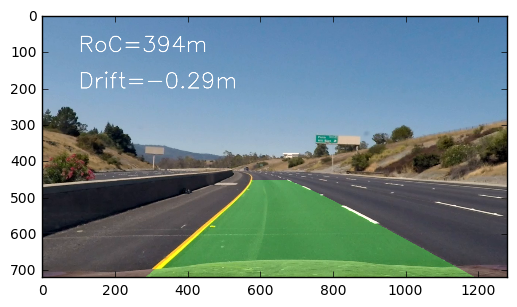

In [25]:
print('Running Lane Detect...')

left_line = Line()
right_line = Line()

result = []
for i in range(len(inp_vid)):
    out = lane_detect(inp_vid[i], mtx, dist, src, dst, left_line, right_line)
    result.append(out)

print('Done')
result_arr = np.array(result)

plt.imshow(result_arr[0])

In [26]:
out = "project_video_out.mp4"

print('Writing output video...')
skio.vwrite(out, result_arr)
print('Done')

Writing output video...
Done
